This notebook implements a seeding method from exisiting velocity measurements, and explores the option of using variable ranges of kernel sizes and skip rates in the end.

In [1]:
import numpy as np
from pygeotools.lib import iolib,geolib,warplib,malib,timelib
from autoRIFT import autoRIFT
from imview import pltlib
import matplotlib.pyplot as plt
import os,sys,glob,shutil

In [2]:
%matplotlib notebook

In [15]:
l_img = '/nobackupp2/sbhusha1/vmap_comparison_testing/Cropped/LC08_L1TP_061018_20180304_20180319_01_T1_B8_s.TIF'
r_img = '/nobackupp2/sbhusha1/vmap_comparison_testing/Cropped/LC08_L1TP_061018_20180608_20180615_01_T1_B8_s.TIF'
seed_vx = '/nobackupp2/sbhusha1/vmap_comparison_testing/its_live/canada_vx.tif'
seed_vy = '/nobackupp2/sbhusha1/vmap_comparison_testing/its_live/canada_vy.tif'

In [16]:
ds_list = warplib.memwarp_multi_fn([l_img,r_img,seed_vx,seed_vy],r='cubicspline',
                                  extent='intersection')


Warping all inputs to the following:
Resolution: 15.0
Extent: [584872.5, 6717982.5, 641572.5, 6755182.5]
Projection: '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubicspline

1 of 4: /nobackupp2/sbhusha1/vmap_comparison_testing/Cropped/LC08_L1TP_061018_20180304_20180319_01_T1_B8_s.TIF
2 of 4: /nobackupp2/sbhusha1/vmap_comparison_testing/Cropped/LC08_L1TP_061018_20180608_20180615_01_T1_B8_s.TIF
3 of 4: /nobackupp2/sbhusha1/vmap_comparison_testing/its_live/canada_vx.tif
nl: 2480 ns: 3780 res: 15.000
4 of 4: /nobackupp2/sbhusha1/vmap_comparison_testing/its_live/canada_vy.tif
nl: 2480 ns: 3780 res: 15.000


In [17]:
l_img_ma,r_img_ma,seed_vy_ma,seed_vx_ma = [iolib.ds_getma(x) for x in ds_list]

##### Set variables, create grid

In [8]:
chip_size_min = 32
chip_size_max = 64
skip_rate = 4
contrast_filter = 'lap'
walis_filter_width = 3

In [24]:
obj = autoRIFT()

In [25]:
obj.I1 = l_img_ma
obj.I2 = r_img_ma

In [105]:
obj.ChipSizeMinX = chip_size_min
obj.ChipSizeMaxX = chip_size_max
# check and refine this
obj.ChipSize0X = chip_size_min
# skip rate setup
obj.SkipSampleX = skip_rate
obj.SkipSampleY = skip_rate
obj.WallisFilterWidth = walis_filter_width

<IPython.core.display.Javascript object>


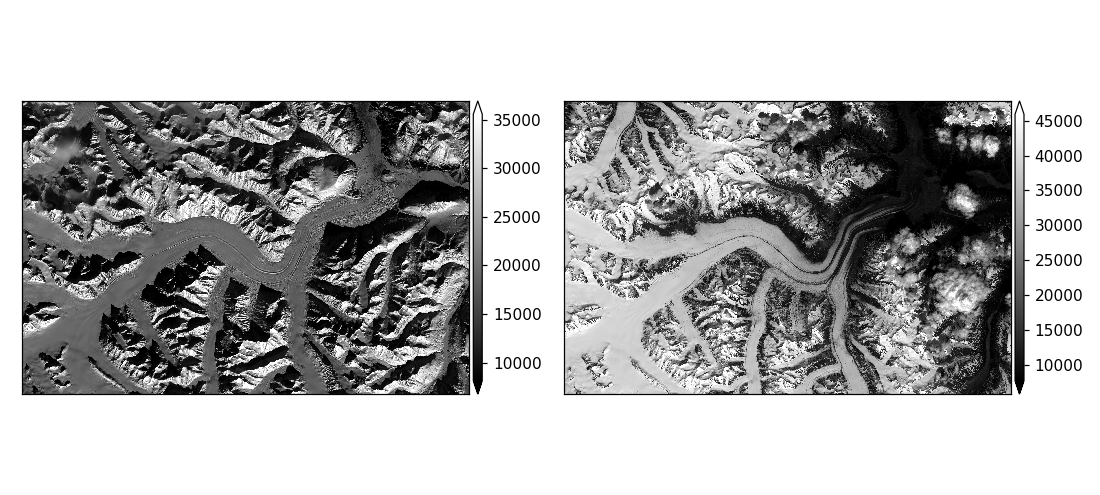

/nobackupp2/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  cmap.set_bad('k', alpha=1)


<AxesSubplot:>

In [27]:
f,ax = plt.subplots(1,2,figsize=(10,4.5))
pltlib.iv(obj.I1,ax=ax[0],cmap='gray')
pltlib.iv(obj.I2,ax=ax[1],cmap='gray')

In [28]:
obj.preprocess_filt_lap()

In [29]:
obj.uniform_data_type()

<IPython.core.display.Javascript object>


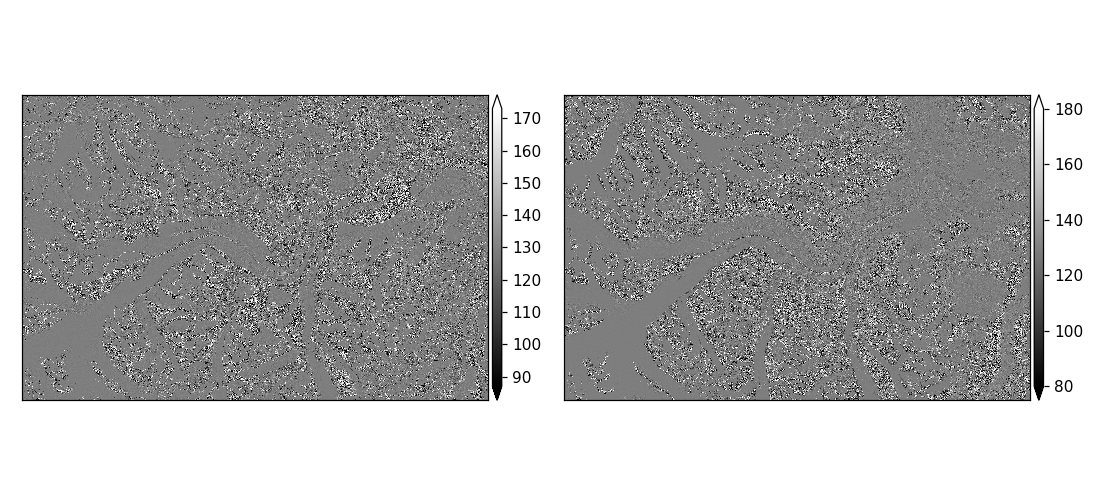

<AxesSubplot:>

In [30]:
f,ax = plt.subplots(1,2,figsize=(10,4.5))
pltlib.iv(obj.I1,ax=ax[0],cmap='gray')
pltlib.iv(obj.I2,ax=ax[1],cmap='gray')

In [32]:
print("creating correlation grid")
# create the grid if it does not exist (from test_autoRIFT.py)
m,n = obj.I1.shape
xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY) 
nd = xGrid.__len__()
md = yGrid.__len__()
obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))
noDataMask = np.logical_not(obj.xGrid)

creating correlation grid


In [33]:
obj.MultiThread = iolib.cpu_count()
obj.SearchLimitX = 10
obj.SearchLimitY = 10

##### first test is with fixed search limit of 10 px

In [34]:
#rerun correlator
%time obj.runAutorift()

/nobackup/sbhusha1/sw/miniconda3/envs/icesat2020/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/nobackup/sbhusha1/sw/miniconda3/envs/icesat2020/lib/python3.7/site-packages/autoRIFT/autoRIFT.py:1398: RuntimeWarning: divide by zero encountered in true_divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2;
/nobackup/sbhusha1/sw/miniconda3/envs/icesat2020/lib/python3.7/site-packages/autoRIFT/autoRIFT.py:1399: RuntimeWarning: divide by zero encountered in true_divide
  DyMadmin = np.ones(Dy.shape) / OverSampleRatio / SearchLimitY * 2;
/nobackup/sbhusha1/sw/miniconda3/envs/icesat2020/lib/python3.7/site-packages/autoRIFT/autoRIFT.py:1352: RuntimeWarning: Mean of empty slice
  C = np.nanmean(B,axis=0).reshape(output_size)


CPU times: user 54.6 s, sys: 1min 50s, total: 2min 44s
Wall time: 7min 35s


<IPython.core.display.Javascript object>


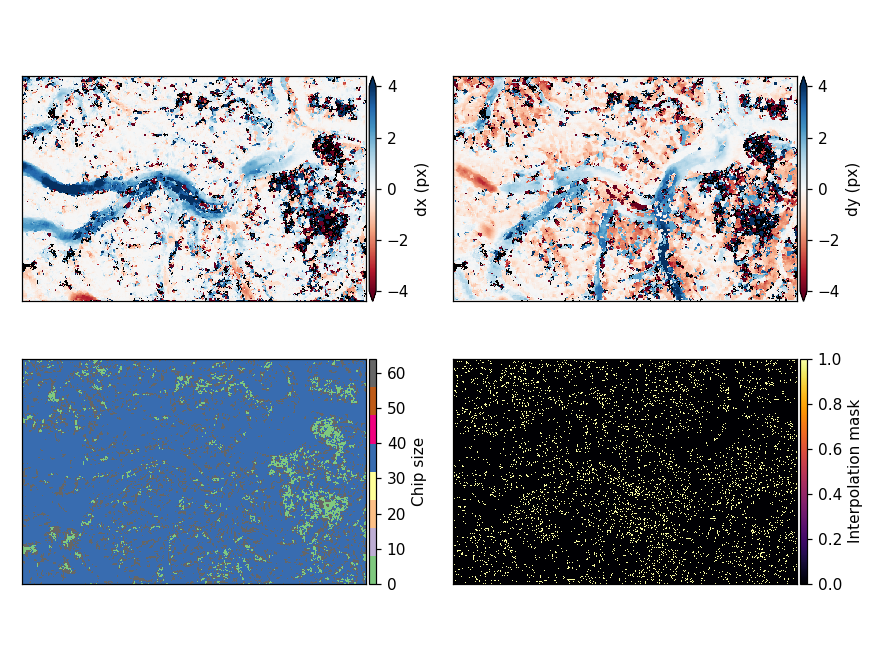

/nobackupp2/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad('k', alpha=1)
/nobackupp2/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Accent"))
  cmap.set_bad('k', alpha=1)
/nobackupp2/sbhusha1/sw/imview/imview/lib/pltlib.py:146: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning,

<AxesSubplot:>

In [36]:
f,axa = plt.subplots(2,2,figsize=(8,6))
clim = (-4,4)
ax = axa.ravel()
pltlib.iv(np.ma.fix_invalid(obj.Dx),ax=ax[0],cmap='RdBu',label='dx (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.Dy),ax=ax[1],cmap='RdBu',label='dy (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.ChipSizeY),ax=ax[2],cmap='Accent',label='Chip size')
pltlib.iv(np.ma.array(obj.InterpMask),ax=ax[3],cmap='inferno',label='Interpolation mask')


#### For the above result, we had used a fixed search limit of 10 px throughout (see below). We can do better job than this, as we know that expeced offset over the static surface should be lower in magnitude, while over the glaciers, it can be variable. We can potentially make use of the existing knowledge we have about glacier flow (pre-existing velocity), and say that the velocity of the current pair can only be in x% +/- range of the established velocity range.

<IPython.core.display.Javascript object>


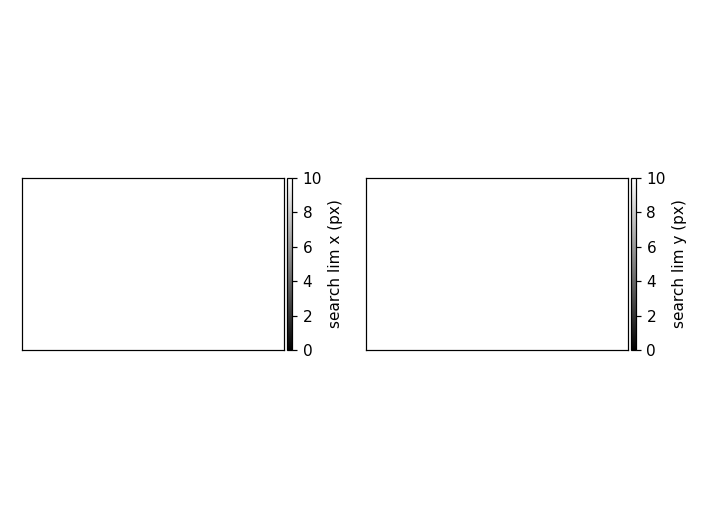

<AxesSubplot:>

In [40]:
f,ax = plt.subplots(1,2)
pltlib.iv(np.ma.array(obj.SearchLimitX),ax=ax[0],cmap='gray',label='search lim x (px)',clim=(0,10))
pltlib.iv(np.ma.array(obj.SearchLimitY),ax=ax[1],cmap='gray',label='search lim y (px)',clim=(0,10))

### explore its_live vx and vy velocity

<IPython.core.display.Javascript object>


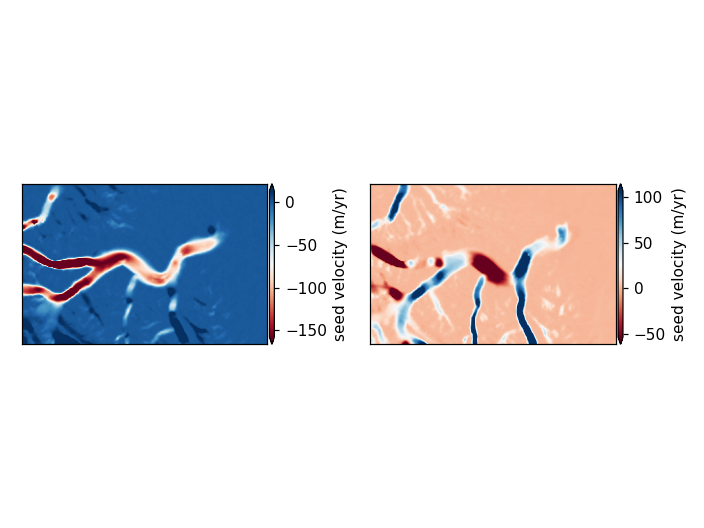

<AxesSubplot:>

In [18]:
f,ax = plt.subplots(1,2)
pltlib.iv(seed_vx_ma,ax=ax[0] ,label='seed velocity (m/yr)',cmap='RdBu')
pltlib.iv(seed_vy_ma,ax=ax[1] ,label='seed velocity (m/yr)',cmap='RdBu')

This is in m/yr. We need it in px units. We can determine the expected velocity in our three months time period by scaling this using the time period appropriately. Then, we can divide by pixel resolution in x and y to scale to get expected px offset. I need to check the way I extracted vx and vy from netcdf, it seemed to be reversed, thats why I switched order of reading masked array.

In [7]:
dt_list = [timelib.fn_getdatetime(x) for x in [l_img,r_img]]
t_factor = timelib.get_t_factor(dt_list[0],dt_list[1]) 
print(f"Time factor is {t_factor} yr units")

Time factor is 0.26283367556468173 yr units


In [19]:
# adjust velocity for time by multiplying by above units
seed_vx_ma = seed_vx_ma * t_factor
seed_vy_ma = seed_vy_ma * t_factor
# adjust for pixel resolution of 15 m
res = geolib.get_res(ds_list[0],square=True)[0]
seed_vx_ma = seed_vx_ma/res
seed_vy_ma = seed_vy_ma/res

<IPython.core.display.Javascript object>


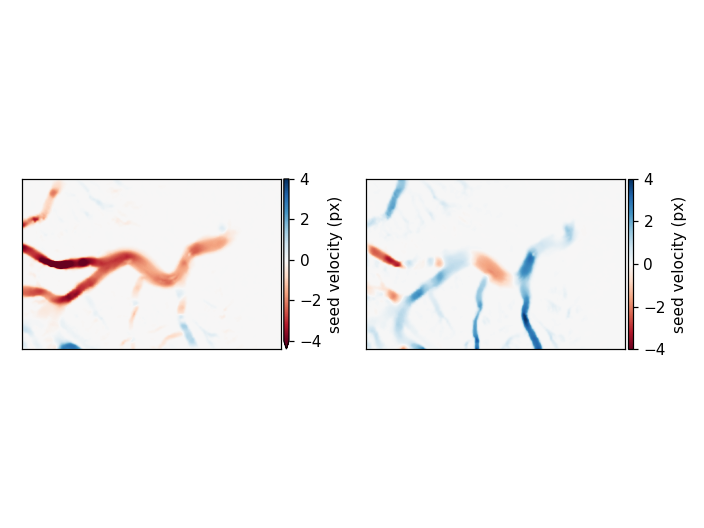

<AxesSubplot:>

In [20]:
f,ax = plt.subplots(1,2)
pltlib.iv(seed_vx_ma,ax=ax[0] ,label='seed velocity (px)',cmap='RdBu',clim=(-4,4))
pltlib.iv(seed_vy_ma,ax=ax[1] ,label='seed velocity (px)',cmap='RdBu',clim=(-4,4))

The above figure shows that the expected velocity have been converted to pixels. Now we will sample this to our correlation grid coordinates.

We will use the ndimage map_coordinates function again to sample the larger array to pixel for our correlation grid.

In [11]:
import scipy.ndimage

ok, so no blunders created :). In the first iterations, we will use this as is, just after making it absolute and converting to next big integers. Then, we will introduce a fudge factor around the above to provide flexibility, as we know that the glaciers flow can change a bit :D 

In [32]:
obj = autoRIFT()
obj.I1 = l_img_ma
obj.I2 = r_img_ma
chip_size_min = 32
chip_size_max = 64
obj.ChipSizeMinX = chip_size_min
obj.ChipSizeMaxX = chip_size_max
# check and refine this
obj.ChipSize0X = chip_size_min
# skip rate setup
skip_rate = 4
walis_filter_width = 3
obj.SkipSampleX = skip_rate
obj.SkipSampleY = skip_rate
obj.WallisFilterWidth = walis_filter_width
obj.preprocess_filt_lap()
obj.uniform_data_type()

In [35]:
print("creating correlation grid")
# create the grid if it does not exist (from test_autoRIFT.py)
m,n = obj.I1.shape
xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY) 
nd = xGrid.__len__()
md = yGrid.__len__()
obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))
noDataMask = np.logical_not(obj.xGrid)
yx = np.array([np.ma.array(obj.yGrid).compressed(),np.ma.array(obj.xGrid).compressed()])
seed_vx_samples = scipy.ndimage.map_coordinates(seed_vx_ma,yx,order=1,mode='nearest')
seed_vy_samples = scipy.ndimage.map_coordinates(seed_vy_ma,yx,order=1,mode='nearest')
## get initial coordinate position using meshgrid
ny,nx = obj.xGrid.shape
nx_val = np.arange(0,nx)
ny_val = np.arange(0,ny)
NX,NY = np.meshgrid(nx_val,ny_val)
seed_vx_subsample = np.zeros_like(obj.xGrid,dtype=float)
seed_vx_subsample[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = seed_vx_samples
seed_vy_subsample = np.zeros_like(obj.xGrid,dtype=float)
seed_vy_subsample[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = seed_vy_samples

creating correlation grid


<IPython.core.display.Javascript object>


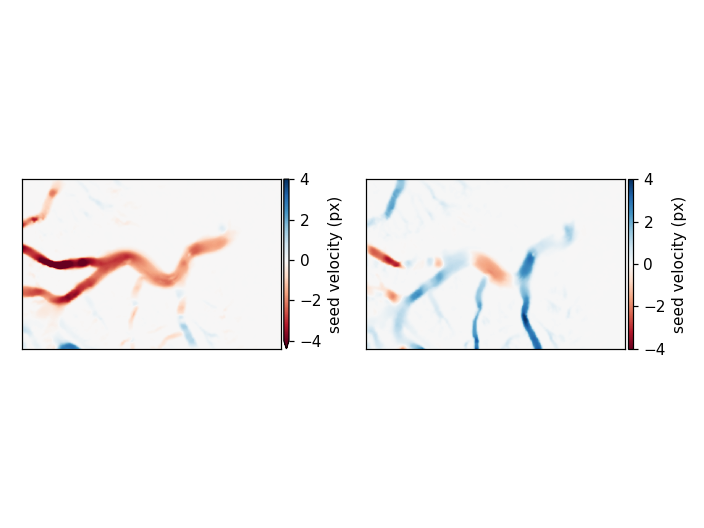

<AxesSubplot:>

In [36]:
f,ax = plt.subplots(1,2)
pltlib.iv(seed_vx_subsample,ax=ax[0] ,label='seed velocity (px)',cmap='RdBu',clim=(-4,4))
pltlib.iv(seed_vy_subsample,ax=ax[1] ,label='seed velocity (px)',cmap='RdBu',clim=(-4,4))

#### plot the subsampled expected pixel displacement map for sanity check

In [37]:
obj.MultiThread = iolib.cpu_count()
obj.SearchLimitX = np.ma.ceil(np.ma.abs(seed_vx_subsample))
obj.SearchLimitY = np.ma.ceil(np.ma.abs(seed_vy_subsample))

In [38]:
seed_vx_subsample.shape

(616, 941)

<IPython.core.display.Javascript object>


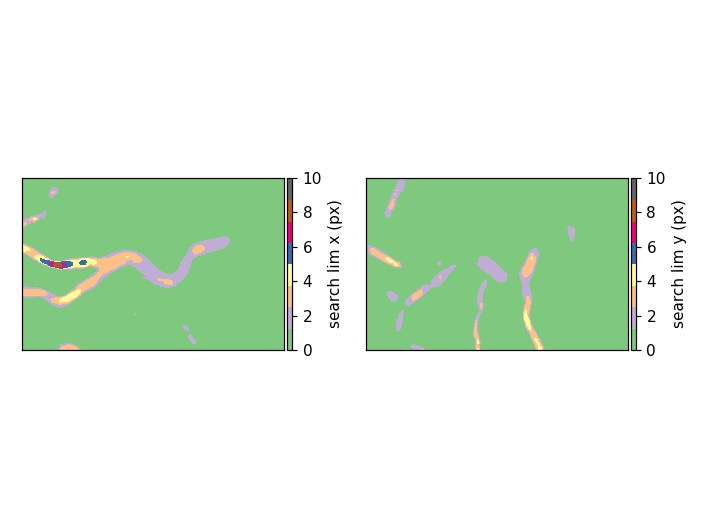

/nobackupp2/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Accent"))
  cmap.set_bad('k', alpha=1)


<AxesSubplot:>

In [39]:
f,ax = plt.subplots(1,2)
pltlib.iv(obj.SearchLimitX,ax=ax[0],cmap='Accent',label='search lim x (px)',clim=(0,10))
pltlib.iv(obj.SearchLimitY,ax=ax[1],cmap='Accent',label='search lim y (px)',clim=(0,10))

In [40]:
#rerun correlator, fingers crossed
%time obj.runAutorift()

/nobackup/sbhusha1/sw/miniconda3/envs/icesat2020/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/nobackup/sbhusha1/sw/miniconda3/envs/icesat2020/lib/python3.7/site-packages/autoRIFT/autoRIFT.py:1398: RuntimeWarning: divide by zero encountered in true_divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2;
/nobackup/sbhusha1/sw/miniconda3/envs/icesat2020/lib/python3.7/site-packages/autoRIFT/autoRIFT.py:1399: RuntimeWarning: divide by zero encountered in true_divide
  DyMadmin = np.ones(Dy.shape) / OverSampleRatio / SearchLimitY * 2;
/nobackup/sbhusha1/sw/miniconda3/envs/icesat2020/lib/python3.7/site-packages/autoRIFT/autoRIFT.py:1352: RuntimeWarning: Mean of empty slice
  C = np.nanmean(B,axis=0).reshape(output_size)


CPU times: user 58.2 s, sys: 1min 41s, total: 2min 39s
Wall time: 4min 21s


<IPython.core.display.Javascript object>


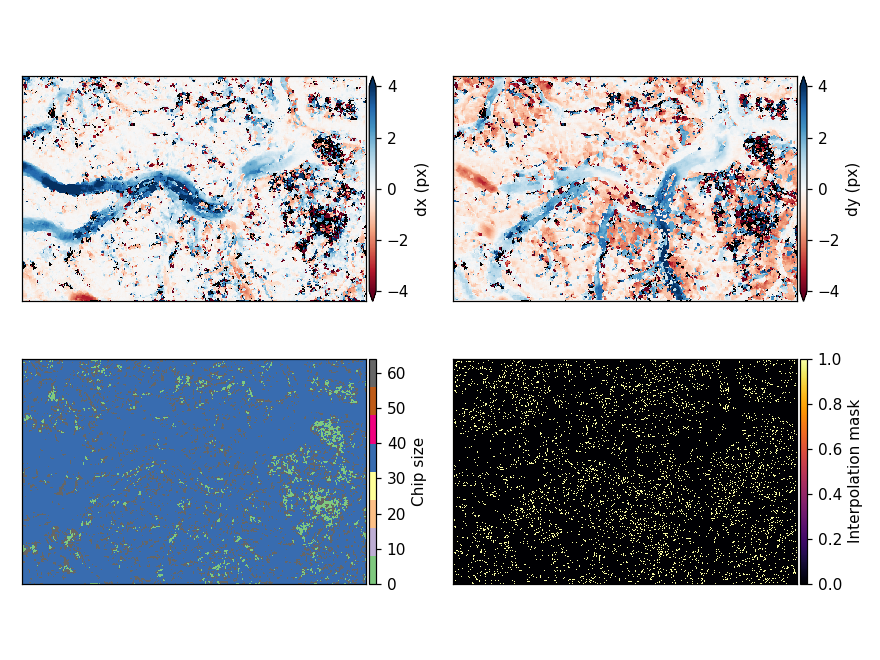

/nobackupp2/sbhusha1/sw/imview/imview/lib/pltlib.py:146: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cmap.set_bad('0.5', alpha=1)


<AxesSubplot:>

In [41]:
f,axa = plt.subplots(2,2,figsize=(8,6))
clim = (-4,4)
ax = axa.ravel()
pltlib.iv(np.ma.fix_invalid(obj.Dx),ax=ax[0],cmap='RdBu',label='dx (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.Dy),ax=ax[1],cmap='RdBu',label='dy (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.ChipSizeY),ax=ax[2],cmap='Accent',label='Chip size')
pltlib.iv(np.ma.array(obj.InterpMask),ax=ax[3],cmap='inferno',label='Interpolation mask')


Ok, so there is an improvement (speed goes down by about 2 mins), but we might be better of being lineant and incoporate fudge factor. 

In [141]:
obj.SearchLimitX

masked_array(
  data=[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

### Fudge factor of 25%

In [42]:
obj = autoRIFT()
obj.I1 = l_img_ma
obj.I2 = r_img_ma
chip_size_min = 32
chip_size_max = 64
obj.ChipSizeMinX = chip_size_min
obj.ChipSizeMaxX = chip_size_max
# check and refine this
obj.ChipSize0X = chip_size_min
# skip rate setup
skip_rate = 4
obj.SkipSampleX = skip_rate
obj.SkipSampleY = skip_rate
walis_filter_width = 3
obj.WallisFilterWidth = walis_filter_width
obj.preprocess_filt_lap()
obj.uniform_data_type()

In [43]:
print("creating correlation grid")
# create the grid if it does not exist (from test_autoRIFT.py)
m,n = obj.I1.shape
xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY) 
nd = xGrid.__len__()
md = yGrid.__len__()
obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))
noDataMask = np.logical_not(obj.xGrid)
yx = np.array([np.ma.array(obj.yGrid).compressed(),np.ma.array(obj.xGrid).compressed()])
seed_vx_samples = scipy.ndimage.map_coordinates(seed_vx_ma,yx,order=1,mode='nearest')
seed_vy_samples = scipy.ndimage.map_coordinates(seed_vy_ma,yx,order=1,mode='nearest')
## get initial coordinate position using meshgrid
ny,nx = obj.xGrid.shape
nx_val = np.arange(0,nx)
ny_val = np.arange(0,ny)
NX,NY = np.meshgrid(nx_val,ny_val)
seed_vx_subsample = np.zeros_like(obj.xGrid,dtype=float)
seed_vx_subsample[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = seed_vx_samples
seed_vy_subsample = np.zeros_like(obj.xGrid,dtype=float)
seed_vy_subsample[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = seed_vy_samples

creating correlation grid


In [44]:
fudge_factor = 1.25 #(previous value + 25 percent of previous value)
obj.MultiThread = iolib.cpu_count()
obj.SearchLimitX = np.ma.ceil(np.ma.abs(seed_vx_subsample*fudge_factor))
obj.SearchLimitY = np.ma.ceil(np.ma.abs(seed_vy_subsample*fudge_factor))

In [45]:
obj.SearchLimitX

masked_array(
  data=[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],
  mask=False,
  fill_value=1e+20)

In [46]:
obj.ChipSizeMinX

32

In [47]:
obj.ChipSizeMaxX

64

In [48]:
#rerun correlator, fingers crossed
%time obj.runAutorift()

CPU times: user 57.8 s, sys: 1min 39s, total: 2min 37s
Wall time: 4min 33s


<IPython.core.display.Javascript object>


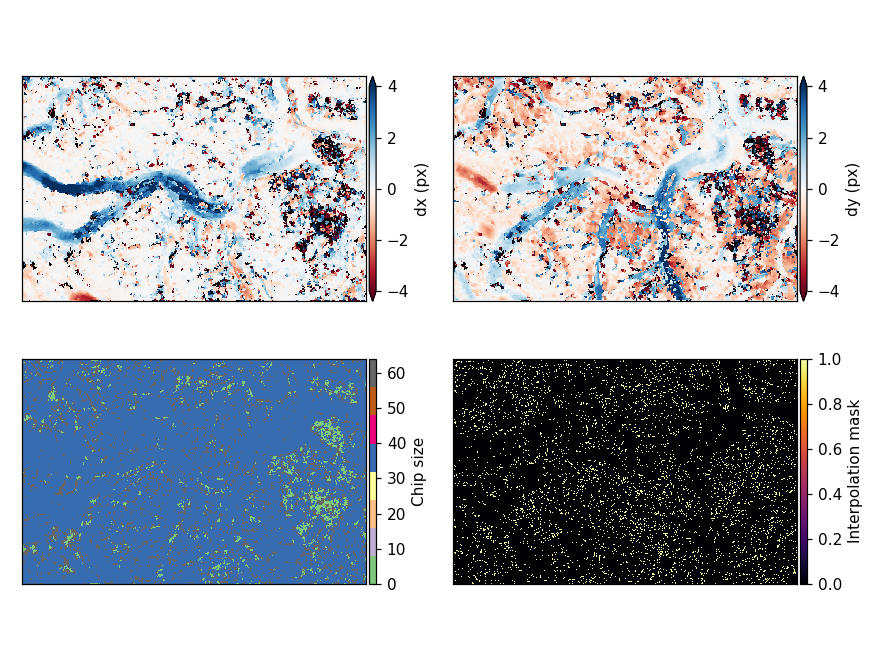

<AxesSubplot:>

In [49]:
f,axa = plt.subplots(2,2,figsize=(8,6))
clim = (-4,4)
ax = axa.ravel()
pltlib.iv(np.ma.fix_invalid(obj.Dx),ax=ax[0],cmap='RdBu',label='dx (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.Dy),ax=ax[1],cmap='RdBu',label='dy (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.ChipSizeY),ax=ax[2],cmap='Accent',label='Chip size')
pltlib.iv(np.ma.array(obj.InterpMask),ax=ax[3],cmap='inferno',label='Interpolation mask')


Ok, this is slightly improved (or maybe not) ! But processing time for this iteration was higher ! Lets try to increase the fudge factor to 50 %.

### Fudge factor 50%

In [50]:
obj = autoRIFT()
obj.I1 = l_img_ma
obj.I2 = r_img_ma
chip_size_min = 32
chip_size_max = 64
obj.ChipSizeMinX = chip_size_min
obj.ChipSizeMaxX = chip_size_max
# check and refine this
obj.ChipSize0X = chip_size_min
# skip rate setup
skip_rate = 4
obj.SkipSampleX = skip_rate
obj.SkipSampleY = skip_rate
walis_filter_width = 3
obj.WallisFilterWidth = walis_filter_width
obj.preprocess_filt_lap()
obj.uniform_data_type()

In [51]:
print("creating correlation grid")
# create the grid if it does not exist (from test_autoRIFT.py)
m,n = obj.I1.shape
xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY) 
nd = xGrid.__len__()
md = yGrid.__len__()
obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))
noDataMask = np.logical_not(obj.xGrid)
yx = np.array([np.ma.array(obj.yGrid).compressed(),np.ma.array(obj.xGrid).compressed()])
seed_vx_samples = scipy.ndimage.map_coordinates(seed_vx_ma,yx,order=1,mode='nearest')
seed_vy_samples = scipy.ndimage.map_coordinates(seed_vy_ma,yx,order=1,mode='nearest')
## get initial coordinate position using meshgrid
ny,nx = obj.xGrid.shape
nx_val = np.arange(0,nx)
ny_val = np.arange(0,ny)
NX,NY = np.meshgrid(nx_val,ny_val)
seed_vx_subsample = np.zeros_like(obj.xGrid,dtype=float)
seed_vx_subsample[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = seed_vx_samples
seed_vy_subsample = np.zeros_like(obj.xGrid,dtype=float)
seed_vy_subsample[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = seed_vy_samples

creating correlation grid


In [52]:
fudge_factor = 1.50 #(previous value + 50 percent of previous value)
obj.MultiThread = iolib.cpu_count()
obj.SearchLimitX = np.ma.ceil(np.ma.abs(seed_vx_subsample*fudge_factor))
obj.SearchLimitY = np.ma.ceil(np.ma.abs(seed_vy_subsample*fudge_factor))

<IPython.core.display.Javascript object>


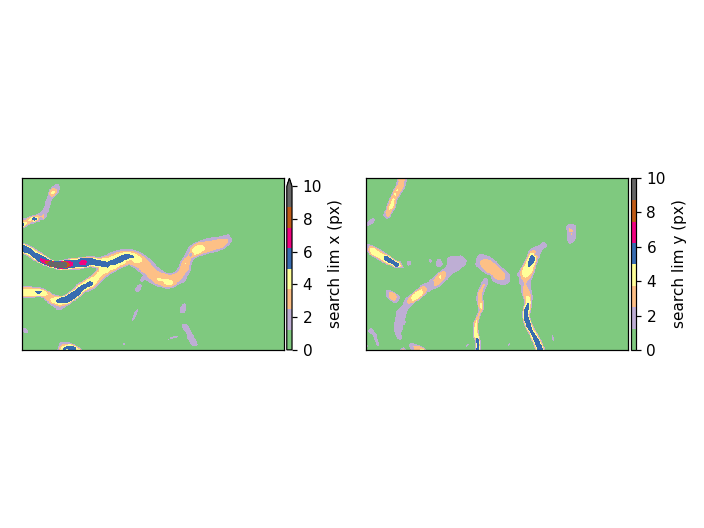

<AxesSubplot:>

In [53]:
f,ax = plt.subplots(1,2)
pltlib.iv(obj.SearchLimitX,ax=ax[0],cmap='Accent',label='search lim x (px)',clim=(0,10))
pltlib.iv(obj.SearchLimitY,ax=ax[1],cmap='Accent',label='search lim y (px)',clim=(0,10))

In [54]:
#rerun correlator, fingers crossed
%time obj.runAutorift()

CPU times: user 56.4 s, sys: 1min 38s, total: 2min 35s
Wall time: 4min 30s


<IPython.core.display.Javascript object>


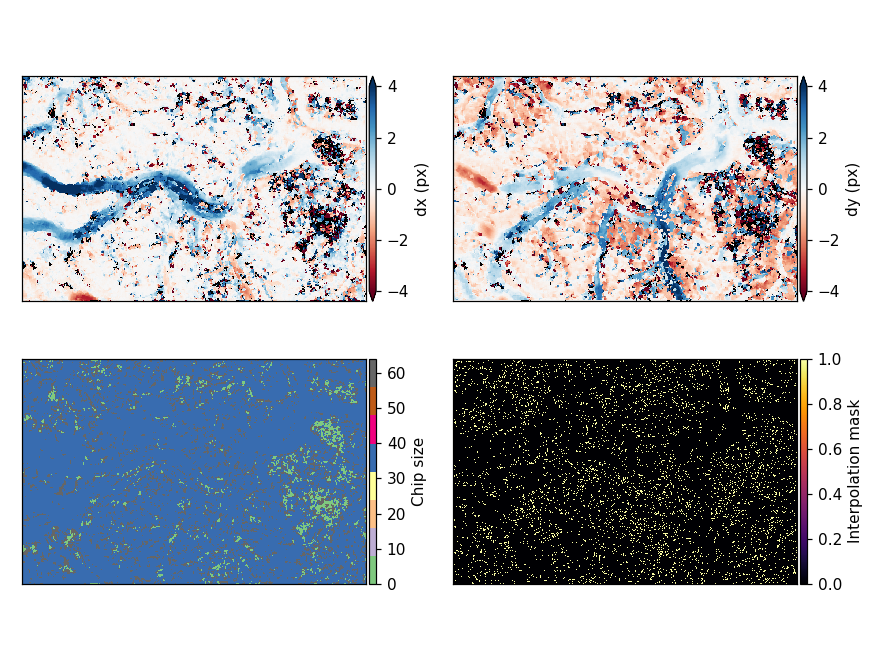

<AxesSubplot:>

In [55]:
f,axa = plt.subplots(2,2,figsize=(8,6))
clim = (-4,4)
ax = axa.ravel()
pltlib.iv(np.ma.fix_invalid(obj.Dx),ax=ax[0],cmap='RdBu',label='dx (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.Dy),ax=ax[1],cmap='RdBu',label='dy (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.ChipSizeY),ax=ax[2],cmap='Accent',label='Chip size')
pltlib.iv(np.ma.array(obj.InterpMask),ax=ax[3],cmap='inferno',label='Interpolation mask')


Ok, this did not help too much than having a fixed search limit throughout. 1 thought though, we can probably use the chip size of zero as a bad data mask, as this is generally correlating with the anamolous values visually ! Lets try that :) m

In [94]:
obj.Dx

array([[        nan,         nan,         nan, ...,  0.0625    ,
         0.0625    ,  0.0625    ],
       [-0.25      , -0.125     , -0.375     , ...,  0.0625    ,
         0.1875    ,  0.125     ],
       [-0.25      , -0.25      , -0.25      , ...,  0.0625    ,
         0.1875    ,  0.125     ],
       ...,
       [-0.0625    ,  0.        , -0.25      , ...,  0.05270004,
         0.04935074,  0.        ],
       [ 0.        , -0.03125   , -0.25      , ...,  0.04495621,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.25      , ...,  0.04025459,
         0.        ,  0.        ]], dtype=float32)

<IPython.core.display.Javascript object>


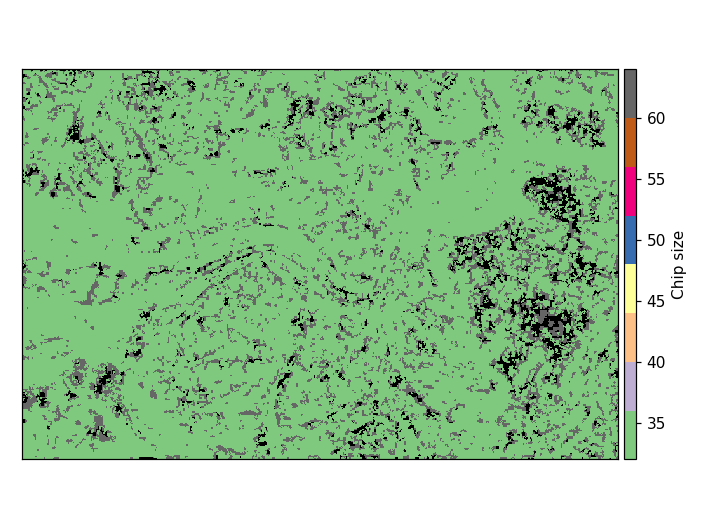

<AxesSubplot:>

In [97]:
chip_masky = np.ma.masked_where(obj.ChipSizeY<0.1,obj.ChipSizeY)
f,ax = plt.subplots()
pltlib.iv(chip_masky,ax=ax,cmap='Accent',label='Chip size')

ok, gleaning through it, I think it is already taken care of.

<IPython.core.display.Javascript object>


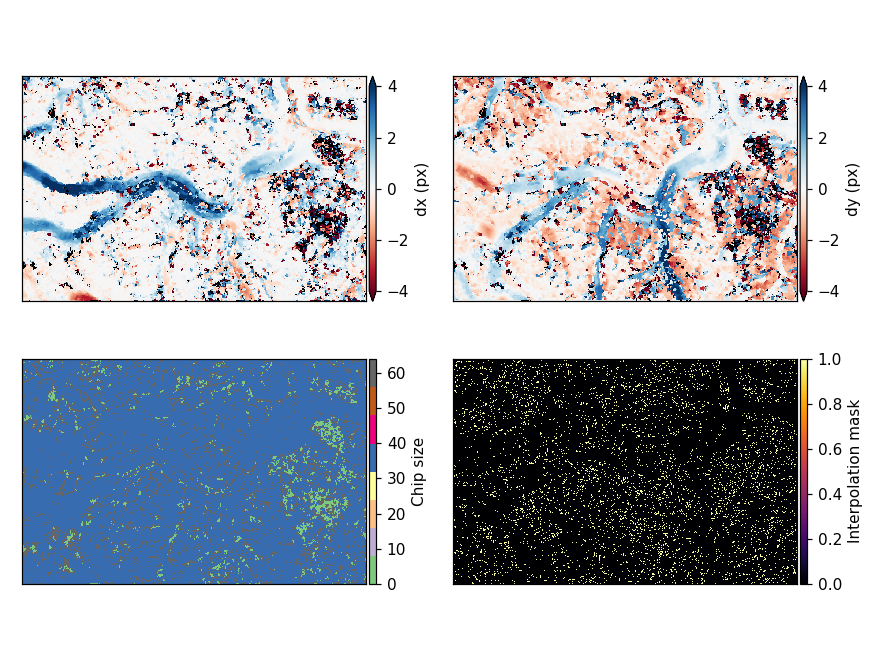

/nobackupp2/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad('k', alpha=1)
/nobackupp2/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Accent"))
  cmap.set_bad('k', alpha=1)
/nobackupp2/sbhusha1/sw/imview/imview/lib/pltlib.py:146: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning,

<AxesSubplot:>

In [99]:
f,axa = plt.subplots(2,2,figsize=(8,6))
clim = (-4,4)
ax = axa.ravel()
pltlib.iv(np.ma.fix_invalid(obj.Dx,mask=chip_masky.mask),ax=ax[0],cmap='RdBu',label='dx (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.Dy,mask=chip_masky.mask),ax=ax[1],cmap='RdBu',label='dy (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.ChipSizeY),ax=ax[2],cmap='Accent',label='Chip size')
pltlib.iv(np.ma.array(obj.InterpMask),ax=ax[3],cmap='inferno',label='Interpolation mask')


### No fudge_factor, but progressively increasing chip_sizes (kernels) from 16 to 64.
In the final step, we will use a search range from 16 to 64, with all other params remaining the same.

In [56]:
obj = autoRIFT()
obj.I1 = l_img_ma
obj.I2 = r_img_ma
chip_size_min = 16
chip_size_max = 64
obj.ChipSizeMinX = chip_size_min
obj.ChipSizeMaxX = chip_size_max
# check and refine this
obj.ChipSize0X = chip_size_min
# skip rate setup
skip_rate = 4
obj.SkipSampleX = skip_rate
obj.SkipSampleY = skip_rate
walis_filter_width = 3
obj.WallisFilterWidth = walis_filter_width
obj.preprocess_filt_lap()
obj.uniform_data_type()

In [57]:
print("creating correlation grid")
# create the grid if it does not exist (from test_autoRIFT.py)
m,n = obj.I1.shape
xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY) 
nd = xGrid.__len__()
md = yGrid.__len__()
obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))
noDataMask = np.logical_not(obj.xGrid)
yx = np.array([np.ma.array(obj.yGrid).compressed(),np.ma.array(obj.xGrid).compressed()])
seed_vx_samples = scipy.ndimage.map_coordinates(seed_vx_ma,yx,order=1,mode='nearest')
seed_vy_samples = scipy.ndimage.map_coordinates(seed_vy_ma,yx,order=1,mode='nearest')
## get initial coordinate position using meshgrid
ny,nx = obj.xGrid.shape
nx_val = np.arange(0,nx)
ny_val = np.arange(0,ny)
NX,NY = np.meshgrid(nx_val,ny_val)
seed_vx_subsample = np.zeros_like(obj.xGrid,dtype=float)
seed_vx_subsample[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = seed_vx_samples
seed_vy_subsample = np.zeros_like(obj.xGrid,dtype=float)
seed_vy_subsample[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = seed_vy_samples

creating correlation grid


In [58]:
obj.MultiThread = iolib.cpu_count()
obj.SearchLimitX = np.ma.ceil(np.ma.abs(seed_vx_subsample))
obj.SearchLimitY = np.ma.ceil(np.ma.abs(seed_vy_subsample))

In [59]:
#rerun correlator, fingers crossed
%time obj.runAutorift()

CPU times: user 1min 2s, sys: 2min, total: 3min 2s
Wall time: 3min 38s


<IPython.core.display.Javascript object>


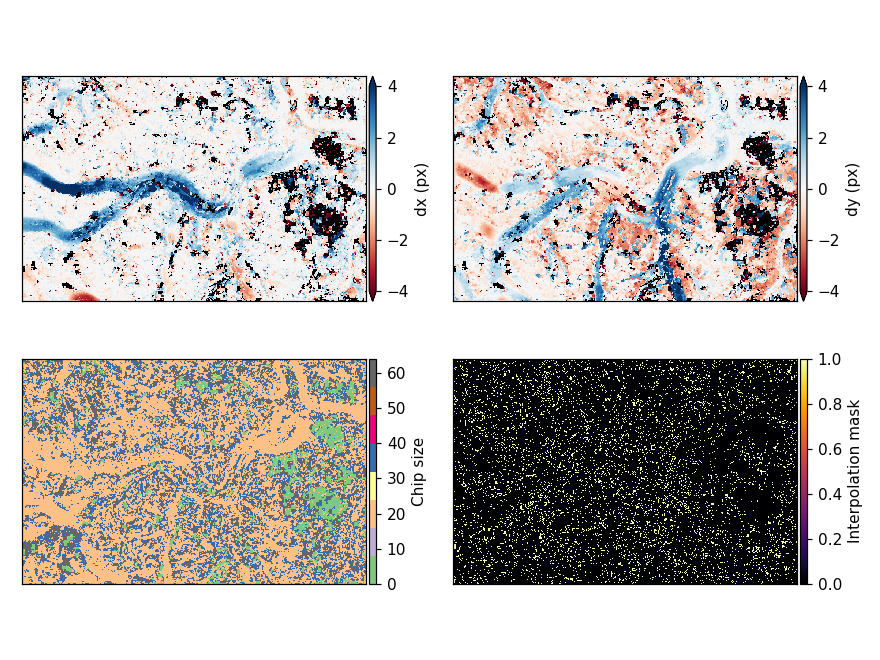

<AxesSubplot:>

In [61]:
f,axa = plt.subplots(2,2,figsize=(8,6))
clim = (-4,4)
ax = axa.ravel()
pltlib.iv(np.ma.fix_invalid(obj.Dx),ax=ax[0],cmap='RdBu',label='dx (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.Dy),ax=ax[1],cmap='RdBu',label='dy (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.ChipSizeY),ax=ax[2],cmap='Accent',label='Chip size')
pltlib.iv(np.ma.array(obj.InterpMask),ax=ax[3],cmap='inferno',label='Interpolation mask')


This strategy did better in skipping the blunders oberved clouds and ran faster as well.

1 last step, we will try to rerun with a smaller (2) and larger (8) skip rate and see how that goes.

### No fudge_factor, chip size from 16 to 64, skip_rate of 2

In [62]:
obj = autoRIFT()
obj.I1 = l_img_ma
obj.I2 = r_img_ma
chip_size_min = 16
chip_size_max = 64
obj.ChipSizeMinX = chip_size_min
obj.ChipSizeMaxX = chip_size_max
# check and refine this
obj.ChipSize0X = chip_size_min
# skip rate setup
skip_rate = 2
obj.SkipSampleX = skip_rate
obj.SkipSampleY = skip_rate
walis_filter_width = 3
obj.WallisFilterWidth = walis_filter_width
obj.preprocess_filt_lap()
obj.uniform_data_type()

In [63]:
print("creating correlation grid")
# create the grid if it does not exist (from test_autoRIFT.py)
m,n = obj.I1.shape
xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY) 
nd = xGrid.__len__()
md = yGrid.__len__()
obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))
noDataMask = np.logical_not(obj.xGrid)
yx = np.array([np.ma.array(obj.yGrid).compressed(),np.ma.array(obj.xGrid).compressed()])
seed_vx_samples = scipy.ndimage.map_coordinates(seed_vx_ma,yx,order=1,mode='nearest')
seed_vy_samples = scipy.ndimage.map_coordinates(seed_vy_ma,yx,order=1,mode='nearest')
## get initial coordinate position using meshgrid
ny,nx = obj.xGrid.shape
nx_val = np.arange(0,nx)
ny_val = np.arange(0,ny)
NX,NY = np.meshgrid(nx_val,ny_val)
seed_vx_subsample = np.zeros_like(obj.xGrid,dtype=float)
seed_vx_subsample[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = seed_vx_samples
seed_vy_subsample = np.zeros_like(obj.xGrid,dtype=float)
seed_vy_subsample[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = seed_vy_samples

creating correlation grid


In [64]:
obj.MultiThread = iolib.cpu_count()
obj.SearchLimitX = np.ma.ceil(np.ma.abs(seed_vx_subsample))
obj.SearchLimitY = np.ma.ceil(np.ma.abs(seed_vy_subsample))

In [65]:
obj.SearchLimitX.shape

(1233, 1883)

In [66]:
#rerun correlator, fingers crossed
%time obj.runAutorift()

/nobackup/sbhusha1/sw/miniconda3/envs/icesat2020/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/nobackup/sbhusha1/sw/miniconda3/envs/icesat2020/lib/python3.7/site-packages/autoRIFT/autoRIFT.py:1398: RuntimeWarning: divide by zero encountered in true_divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2;
/nobackup/sbhusha1/sw/miniconda3/envs/icesat2020/lib/python3.7/site-packages/autoRIFT/autoRIFT.py:1399: RuntimeWarning: divide by zero encountered in true_divide
  DyMadmin = np.ones(Dy.shape) / OverSampleRatio / SearchLimitY * 2;
/nobackup/sbhusha1/sw/miniconda3/envs/icesat2020/lib/python3.7/site-packages/autoRIFT/autoRIFT.py:1352: RuntimeWarning: Mean of empty slice
  C = np.nanmean(B,axis=0).reshape(output_size)


CPU times: user 5min 13s, sys: 5min 13s, total: 10min 26s
Wall time: 13min 49s


<IPython.core.display.Javascript object>


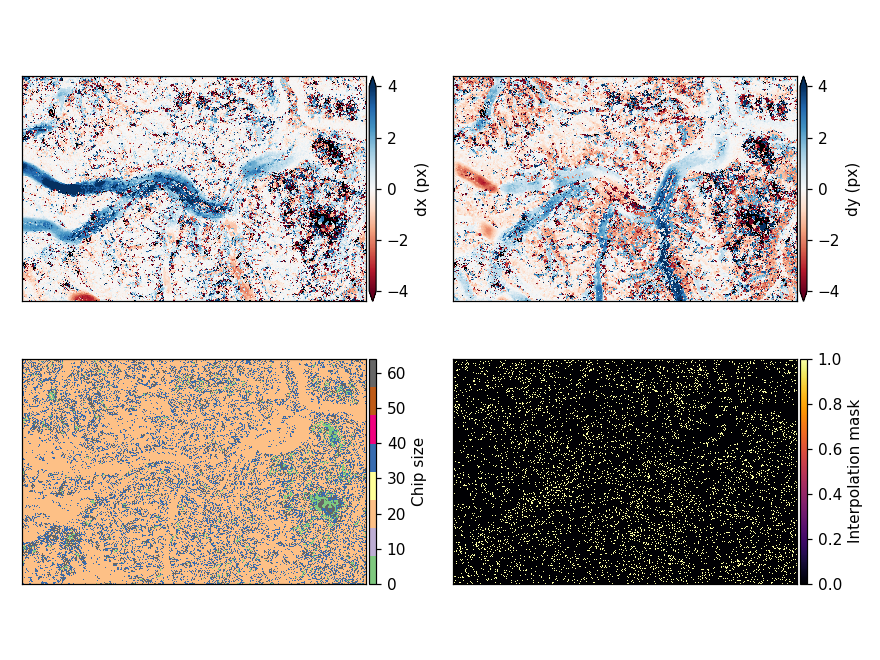

/nobackupp2/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad('k', alpha=1)
/nobackupp2/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Accent"))
  cmap.set_bad('k', alpha=1)
/nobackupp2/sbhusha1/sw/imview/imview/lib/pltlib.py:146: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning,

<AxesSubplot:>

In [67]:
f,axa = plt.subplots(2,2,figsize=(8,6))
clim = (-4,4)
ax = axa.ravel()
pltlib.iv(np.ma.fix_invalid(obj.Dx),ax=ax[0],cmap='RdBu',label='dx (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.Dy),ax=ax[1],cmap='RdBu',label='dy (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.ChipSizeY),ax=ax[2],cmap='Accent',label='Chip size')
pltlib.iv(np.ma.array(obj.InterpMask),ax=ax[3],cmap='inferno',label='Interpolation mask')


### No fudge_factor, chip size from 16 to 64, skip_rate of 8

In [68]:
obj = autoRIFT()
obj.I1 = l_img_ma
obj.I2 = r_img_ma
chip_size_min = 16
chip_size_max = 64
obj.ChipSizeMinX = chip_size_min
obj.ChipSizeMaxX = chip_size_max
# check and refine this
obj.ChipSize0X = chip_size_min
# skip rate setup
skip_rate = 8
obj.SkipSampleX = skip_rate
obj.SkipSampleY = skip_rate
walis_filter_width = 3
obj.WallisFilterWidth = walis_filter_width
obj.preprocess_filt_lap()
obj.uniform_data_type()

In [69]:
print("creating correlation grid")
# create the grid if it does not exist (from test_autoRIFT.py)
m,n = obj.I1.shape
xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY) 
nd = xGrid.__len__()
md = yGrid.__len__()
obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))
noDataMask = np.logical_not(obj.xGrid)
yx = np.array([np.ma.array(obj.yGrid).compressed(),np.ma.array(obj.xGrid).compressed()])
seed_vx_samples = scipy.ndimage.map_coordinates(seed_vx_ma,yx,order=1,mode='nearest')
seed_vy_samples = scipy.ndimage.map_coordinates(seed_vy_ma,yx,order=1,mode='nearest')
## get initial coordinate position using meshgrid
ny,nx = obj.xGrid.shape
nx_val = np.arange(0,nx)
ny_val = np.arange(0,ny)
NX,NY = np.meshgrid(nx_val,ny_val)
seed_vx_subsample = np.zeros_like(obj.xGrid,dtype=float)
seed_vx_subsample[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = seed_vx_samples
seed_vy_subsample = np.zeros_like(obj.xGrid,dtype=float)
seed_vy_subsample[np.ma.array(NY).compressed(),np.ma.array(NX).compressed()] = seed_vy_samples

creating correlation grid


In [70]:
obj.MultiThread = iolib.cpu_count()
obj.SearchLimitX = np.ma.ceil(np.ma.abs(seed_vx_subsample))
obj.SearchLimitY = np.ma.ceil(np.ma.abs(seed_vy_subsample))

In [71]:
obj.SearchLimitX.shape

(307, 470)

In [72]:
#rerun correlator, fingers crossed
%time obj.runAutorift()

CPU times: user 23.9 s, sys: 44.3 s, total: 1min 8s
Wall time: 1min 9s


<IPython.core.display.Javascript object>


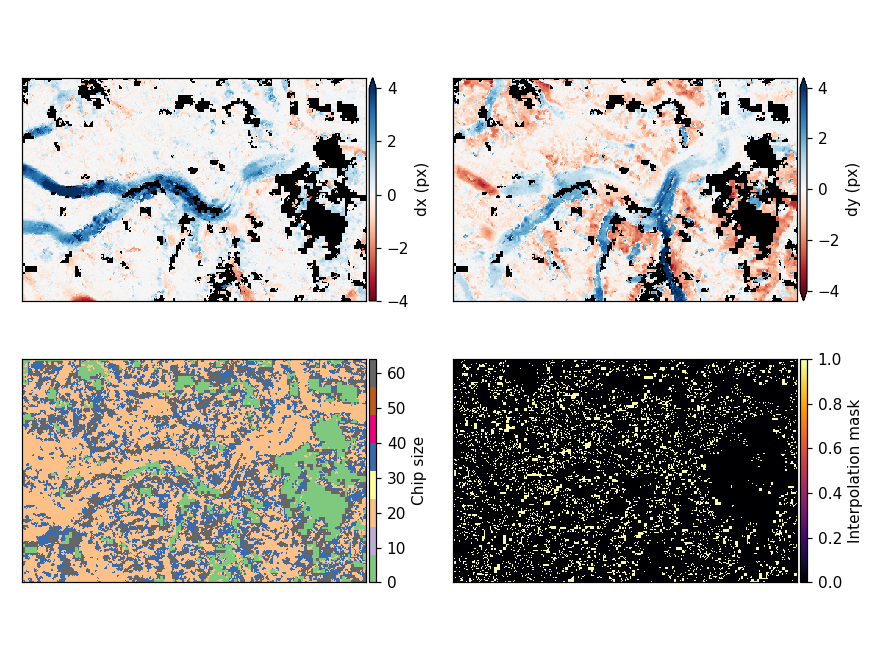

<AxesSubplot:>

In [73]:
f,axa = plt.subplots(2,2,figsize=(8,6))
clim = (-4,4)
ax = axa.ravel()
pltlib.iv(np.ma.fix_invalid(obj.Dx),ax=ax[0],cmap='RdBu',label='dx (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.Dy),ax=ax[1],cmap='RdBu',label='dy (px)',clim=clim)
pltlib.iv(np.ma.fix_invalid(obj.ChipSizeY),ax=ax[2],cmap='Accent',label='Chip size')
pltlib.iv(np.ma.array(obj.InterpMask),ax=ax[3],cmap='inferno',label='Interpolation mask')


Increasing the skip rate, the results become more smoother, with lower noise and but higher data gaps. I think we discussed this during 1 to 1 meeting, if there is a tough group of pixels to correlate (or input data gaps), a large skip rate might skip it all together along with pixels around it, but the at finer resolution, the correlator can still work on the pixels around it, potentially reducing the size of the output data gap in the velocity map. 

Acknowledgements

The seeding scheme is directly inspired from vmap ! 